In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Heat10_1D
problem = Heat10_1D()

# Optimiser

In [3]:
class PlateauLM:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 0.75,
        increase_factor: float = 1.1,
        max_trials: int = 10,
        plateau_factor: float = 0.99,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.max_trials = max_trials
        self.plateau_factor = plateau_factor

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {
            'lambda': jnp.asarray(self.init_lambda),
        }

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array],
        collocation_points
    ):
        current_lambda = state['lambda']
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        # This vectorized function will be used for the initial loss calculation
        def vectorized_residual_fn(p):
            return jax.vmap(residual_fn, in_axes=(None, 0))(p, collocation_points)

        residuals = vectorized_residual_fn(params)
        current_loss = jnp.mean(residuals**2)

        def single_row_jacobian_fn(p_flat, xt):
            # ... (Jacobian calculation code is correct) ...
            static = jax.tree_util.tree_map(lambda x: None if isinstance(x, jax.Array) else x, params)
            def residual_for_jac(p_flat_local):
                model = eqx.combine(unflatten(p_flat_local), static)
                return residual_fn(model, xt).sum()
            
            return jax.grad(residual_for_jac)(p_flat)
        
        J = jax.vmap(single_row_jacobian_fn, in_axes=(None, 0))(params_flat, collocation_points)
        U, S, Vt = jnp.linalg.svd(J, full_matrices=False)
        g = U.T @ residuals
        
        # Hessian_diag = jnp.sum(J**2, axis=0)
        # D = jnp.diag(jnp.sqrt(Hessian_diag))
        # J_hat = J @ jnp.linalg.inv(D)
        
        # U_hat, S_hat, Vt_hat = jnp.linalg.svd(J_hat, full_matrices=False)
        # g_hat = U_hat.T @ residuals


        def evaluate_trial_step(loop_val):
            _, trial_lambda, previous_trial_loss, _, trial_count = loop_val
            delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ g
            
            trial_params = eqx.apply_updates(params, unflatten(delta))
            trial_residuals = vectorized_residual_fn(trial_params)
            
            trial_loss = jnp.mean(trial_residuals**2)
            
            accepted = (trial_loss < current_loss) & (trial_loss > self.plateau_factor * previous_trial_loss)

            # If rejected, increase lambda for the next trial
            new_lambda = jax.lax.cond(
                accepted,
                lambda: trial_lambda,
                lambda: trial_lambda * self.increase_factor
            )
            
            return accepted, new_lambda, trial_loss, delta, trial_count + 1

        def continue_search(loop_val):
            accepted, _, trial_loss, _, trial_count = loop_val
            return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)
        
        # Run the search loop
        initial_loop_val = (False, current_lambda, current_loss, jnp.zeros_like(params_flat), 0)
        
        accepted, final_lambda, new_loss, final_delta, count = jax.lax.while_loop(
            continue_search, evaluate_trial_step, initial_loop_val
        )

        updates = unflatten(final_delta)
        
        new_state = {
            'lambda': final_lambda * self.decrease_factor,
        }
        
        metrics = { 
            'loss': current_loss,
            'singular_values': S, #S,
            'search_direction_norm': jnp.linalg.norm(final_delta),
            'lambda': final_lambda,
            'trial_count': count
        }

        return current_loss, updates, new_state, metrics
    
    
@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points, key):
    key, subkey = jax.random.split(key)

    def residual_fn_for_optimizer(p, x):
        rebuilt_model = eqx.combine(p, static_parts)
        # Corrected call without jnp.expand_dims
        return problem.physics_residual(rebuilt_model, x)

    loss, updates, new_opt_state, metrics = optimiser.update(
        params, opt_state, residual_fn_for_optimizer, collocation_points
    )
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics, key

@partial(jax.jit, static_argnums=(2, 3, 4, 5))
def resample_rad(
    model, 
    candidate_points, 
    n_points_to_sample, 
    problem, # Pass the problem instance for its residual function
    k, # RAD hyperparameter
    c, # RAD hyperparameter
    key
):
    # 1. Calculate PDE residuals for all candidate points
    # Call the vmapped physics_residual function with the model and the batch of points
    vmapped_residual_fn = jax.vmap(problem.physics_residual, in_axes=(None, 0))
    residuals = vmapped_residual_fn(model, candidate_points)
        
    # 2. Compute sampling probability based on the RAD formula
    epsilon_k = jnp.abs(residuals)**k
    weights = (epsilon_k / jnp.mean(epsilon_k)) + c
    probs = weights / jnp.sum(weights)

    # 3. Sample new points based on the calculated probabilities
    indices = jax.random.choice(
        key, 
        a=candidate_points.shape[0], 
        shape=(n_points_to_sample,), 
        p=probs,
        replace=False # Sample without replacement
    )
    
    return candidate_points[indices]

In [4]:
key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_collocation_points = 2**15
n_candidate_points = 10 * n_collocation_points # Much larger pool
layer_sizes = [11, 20, 20, 20, 20, 20, 1]
# -----------------------

# --- New Hyperparameters for RAD ---
resample_every_n_epochs = 50
rad_k = 1.0
rad_c = 1.0
# -----------------------------------

model_key, data_key, resample_key = jax.random.split(key, 3)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()

# 1. Generate the candidate pool ONCE
candidate_points = problem.get_candidate_points(n_candidate_points, seed=1)

# 2. Get the initial set of collocation points
collocation_points = jax.random.choice(data_key, candidate_points, shape=(n_collocation_points,), replace=False)

print(collocation_points.shape)

start_time = time.monotonic()

epoch = 0

(32768, 11)


In [5]:
optimiser = PlateauLM(
    init_lambda=1e5,
    decrease_factor=0.5,
    increase_factor=1.01,
    max_trials=500,
    plateau_factor=0.99,
)
opt_state = optimiser.init(params)

In [6]:
for _ in range(200):
    epoch += 1
    
    # 3. Periodically resample points using RAD
    if epoch % resample_every_n_epochs == 0 and epoch > 0:
        resample_key, subkey = jax.random.split(resample_key)
        
        # We need the full model to calculate residuals for resampling
        current_model = eqx.combine(params, static) 
        
        collocation_points = resample_rad(
            current_model, 
            candidate_points, 
            n_collocation_points, 
            problem,
            rad_k,
            rad_c,
            subkey
        )
        
    params, opt_state, loss_val, metrics, key = train_step(
        params, static, opt_state, optimiser, problem, collocation_points, key
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")
        print(history.history["lambda"][-1])

model = eqx.combine(params, static)
print("Training complete.")

Epoch 20, Loss: 2.203e-01, Time elapsed: 27.63 s
90.82658
Epoch 40, Loss: 1.134e-01, Time elapsed: 52.15 s
1.3739927
Epoch 60, Loss: 2.434e+00, Time elapsed: 92.82 s
25.81406
Epoch 80, Loss: 1.561e+00, Time elapsed: 119.56 s
5.56459
Epoch 100, Loss: 1.192e+00, Time elapsed: 146.88 s
2.222979
Epoch 120, Loss: 1.498e+00, Time elapsed: 173.69 s
1.1053696
Epoch 140, Loss: 6.972e-01, Time elapsed: 204.40 s
55.615448
Epoch 160, Loss: 2.031e+00, Time elapsed: 230.91 s
6.665177
Epoch 180, Loss: 1.033e+00, Time elapsed: 258.32 s
12.325507
Epoch 200, Loss: 7.616e-01, Time elapsed: 287.68 s
177.0108
Training complete.


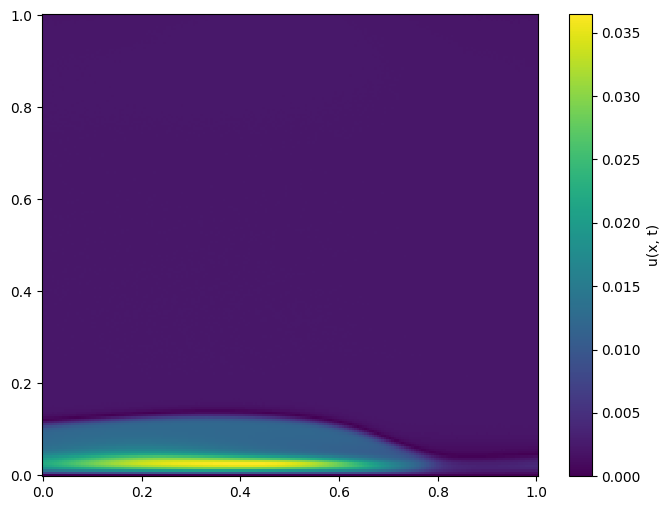

In [15]:
# slice_val = 0.025

fixed_spatial_slice_vals = jnp.array([
0.4317137,  0.23465526, 0.03197992, 0.4433496,  0.40860343,
 0.0037719,  0.46812153, 0.17372525, 0.16002357
])


num_points = 200

x_grid = jnp.linspace(0, 1, num_points)
t_grid = jnp.linspace(0, 1, num_points)

X, T = jnp.meshgrid(x_grid, t_grid)

x_flat = X.flatten()
t_flat = T.flatten()
# fixed_dims_flat = [jnp.full_like(x_flat, slice_val) for _ in range(9)]

fixed_dims_flat = [jnp.full_like(x_flat, val) for val in fixed_spatial_slice_vals]

spatial_coords_flat = jnp.stack(
    [x_flat] + fixed_dims_flat,
    axis=-1
)

@jax.vmap
def vectorized_solution(xs, t):
    return model.predict(xs, t)

U_predict = vectorized_solution(spatial_coords_flat, t_flat).reshape(X.shape)

fig, ax = plt.subplots(figsize=(8, 6))
pcolormesh = ax.pcolormesh(X, T, np.abs(U_predict), shading='auto', cmap='viridis')
fig.colorbar(pcolormesh, ax=ax, label='u(x, t)')

plt.show()

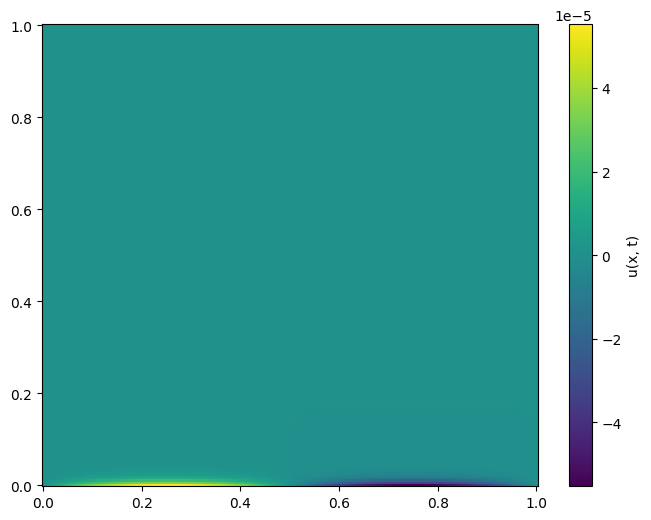

In [16]:
fixed_spatial_slice_vals = jnp.array([
0.4317137,  0.23465526, 0.03197992, 0.4433496,  0.40860343,
 0.0037719,  0.46812153, 0.17372525, 0.16002357
])

num_points = 200

x_grid = jnp.linspace(0, 1, num_points)
t_grid = jnp.linspace(0, 1, num_points)

X, T = jnp.meshgrid(x_grid, t_grid)

x_flat = X.flatten()
t_flat = T.flatten()
# fixed_dims_flat = [jnp.full_like(x_flat, slice_val) for _ in range(9)]

fixed_dims_flat = [jnp.full_like(x_flat, val) for val in fixed_spatial_slice_vals]

input_points_flat = jnp.stack(
    [x_flat] + fixed_dims_flat,
    axis=-1
)

@jax.vmap
def vectorized_solution(xs, t):
    return problem.exact_solution_at_point(xs, t)

U_exact = vectorized_solution(input_points_flat, t_flat).reshape(X.shape)

fig, ax = plt.subplots(figsize=(8, 6))
pcolormesh = ax.pcolormesh(X, T, U_exact, shading='auto', cmap='viridis')
fig.colorbar(pcolormesh, ax=ax, label='u(x, t)')

plt.show()

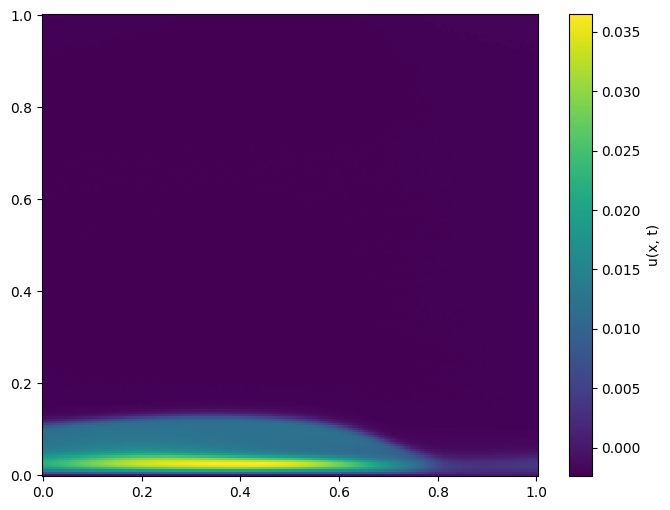

In [9]:
U_exact = vectorized_solution(input_points_flat, t_flat).reshape(X.shape)

fig, ax = plt.subplots(figsize=(8, 6))
pcolormesh = ax.pcolormesh(X, T, U_exact - U_predict, shading='auto', cmap='viridis')
fig.colorbar(pcolormesh, ax=ax, label='u(x, t)')

plt.show()

In [10]:
model = eqx.combine(params, static)

In [11]:
def calculate_l2_relative_error(problem, model, test_points):
    
    @jax.vmap
    def error_at_point(tp):
        u_exact = problem.exact_solution_at_point(tp[:10], tp[10])
        u_model = model.predict(tp[:10], tp[10])
        
        squared_error = (u_exact - u_model)**2
        squared_exact_solution = u_exact**2
        
        return squared_error, squared_exact_solution

    sum_squared_error, sum_squared_exact_solution = jax.tree_util.tree_map(
        lambda x: jnp.sum(x),
        error_at_point(test_points)
    )
    
    l2_relative_error = jnp.sqrt(sum_squared_error / sum_squared_exact_solution)
    
    return l2_relative_error

In [12]:
test_points = problem.get_candidate_points(100, seed=1)
l2_error = calculate_l2_relative_error(problem, model, test_points)
print(f"L2 Relative Error: {l2_error}")

L2 Relative Error: 22.074176788330078


In [13]:
test_points = problem.get_candidate_points(20, seed=2)
for tp in test_points:
    u_exact = problem.exact_solution_at_point(jnp.array(tp[:10]), jnp.array(tp[10]))
    u_model = model(jnp.array(tp))
    print(u_exact, u_model, np.abs(u_exact - u_model), "\n", tp)

6.519936e-29 0.0023109869 0.0023109869 
 [0.64079106 0.900602   0.23003411 0.88161016 0.41823173 0.20232177
 0.7334719  0.18748105 0.7555975  0.808164   0.63629305]
-1.6452036e-30 0.0021343932 0.0021343932 
 [0.93291986 0.09285784 0.94967616 0.32089913 0.6595864  0.81580305
 0.34668255 0.6324496  0.1879803  0.03445387 0.64283216]
4.639604e-09 -0.01227325 0.012273255 
 [0.34993458 0.4317137  0.23465526 0.03197992 0.4433496  0.40860343
 0.0037719  0.46812153 0.17372525 0.16002357 0.09294879]
-5.132732e-38 0.0040452294 0.0040452294 
 [0.9887235  0.82027686 0.49536526 0.03165078 0.10123217 0.85189164
 0.9676659  0.05192173 0.7704611  0.38808274 0.7500938 ]
-5.896224e-29 0.0021073436 0.0021073436 
 [0.8252108  0.56194305 0.06333733 0.5866914  0.48082685 0.22387612
 0.5579654  0.8277664  0.40995932 0.27818727 0.5915314 ]
1.0198015e-15 0.0020876045 0.0020876045 
 [0.42083716 0.27043235 0.88453543 0.67017055 0.07813334 0.7196226
 0.10341775 0.85201585 0.8073876  0.71463144 0.32061946]
9.257247

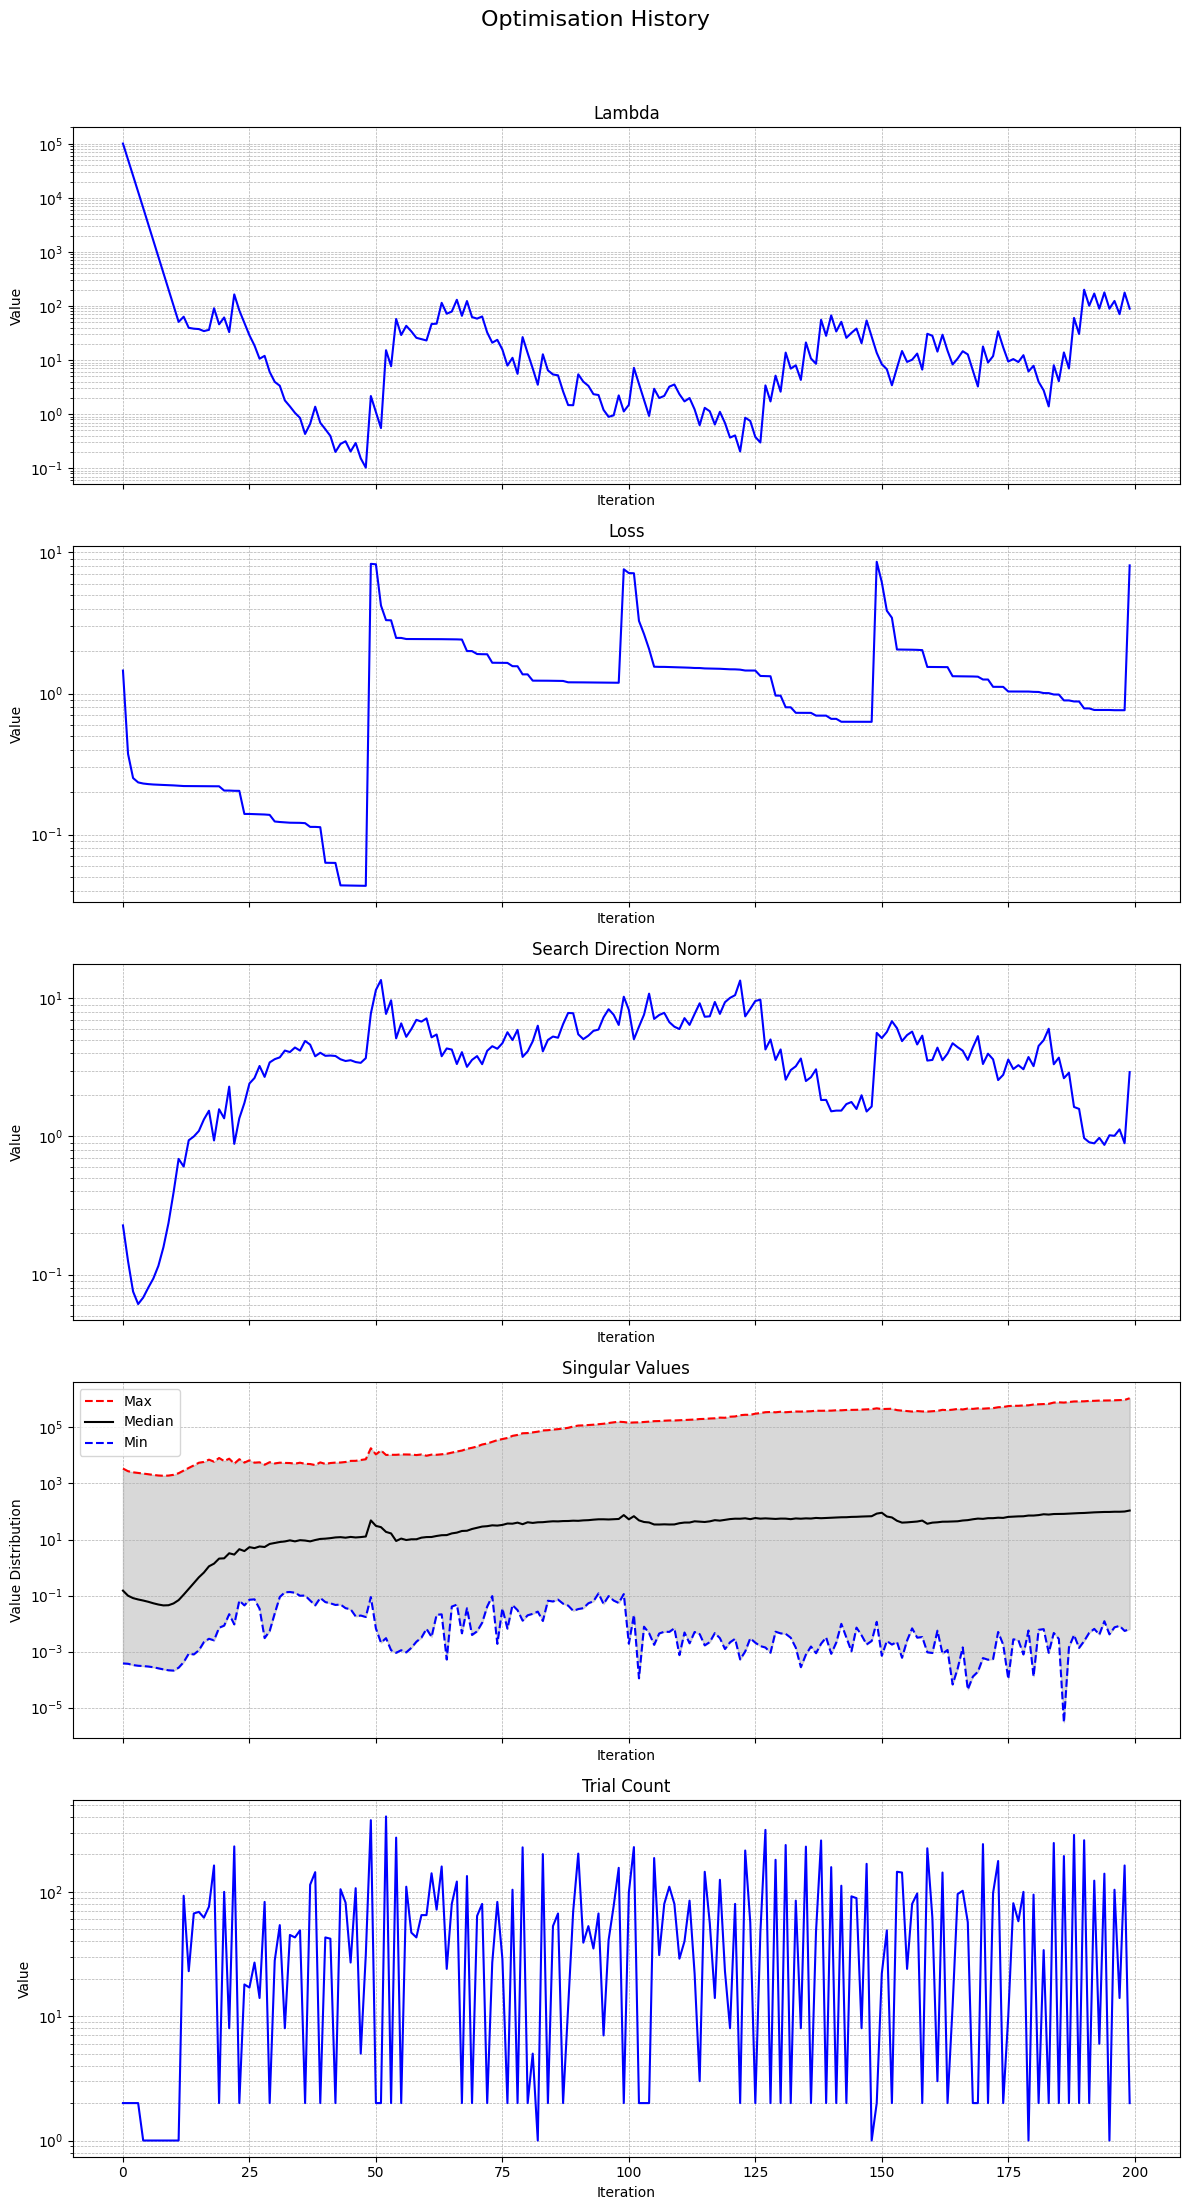

In [14]:
history.plot()